In [52]:
from __future__ import absolute_import, division, print_function
%matplotlib inline
import cv2
import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt
import time
import torch
from torchvision import transforms
import scipy.misc as smp
from geometry_utils import *
import open3d as o3d
import networks
from utils import download_model_if_doesnt_exist

Preparing the Model

In [42]:
model_name = "mono_640x192"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

Load Image

In [43]:
    image_path = "assets/s1.png"
    
    input_image = pil.open(image_path).convert('RGB')

    original_width, original_height = input_image.size

    feed_height = loaded_dict_enc['height']
    feed_width = loaded_dict_enc['width']
    input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

    input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)
    input_npy = input_image_pytorch.squeeze().cpu().numpy()


Predicting disparity from image

In [44]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]

Converting disparity into depth map with relative depth


In [45]:
def disp_to_depth(disp,min_depth,max_depth):
    min_disp = 1/max_depth
    max_disp = 1/min_depth
    print("min->"+str(min_disp)+"mx->"+str(max_disp))
    scaled_disp = min_disp + (max_disp - min_disp)*disp
    dis = 1/scaled_disp
    return scaled_disp,dis

In [46]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False) # interpolate the values in to fit the given resolution of the image

disp_resized_np = disp_resized.squeeze().cpu().numpy() # Converting tensor in pytorch to numpy array
print("resized disp" + str(disp_resized_np.shape))
scaled,dep = disp_to_depth(disp_resized_np,0.1,1000) # resizing the depth from 0.1 to 100 units
dep.shape

resized disp(1420, 1778)
min->0.001mx->10.0


(1420, 1778)

Plotting the original and depth image

In [47]:
rgb_depth = []

In [48]:
rgb = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
rgb_depth.append(rgb)

In [49]:
depth = dep.reshape((rgb.shape[0],rgb.shape[1]),order='C')
rgb_depth.append(depth)

In [50]:
dep.shape

(1420, 1778)

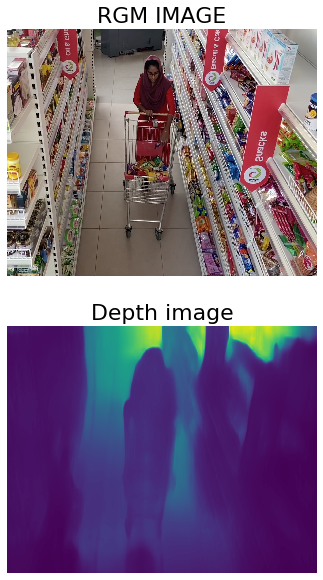

In [51]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(rgb)
plt.title("RGM IMAGE", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(depth)
plt.title("Depth image", fontsize=22)
plt.axis('off');

## Generating 3-D points from depth image

In [54]:
col = rgb.copy()
rgb_t =col.reshape((rgb.shape[0]*rgb.shape[1],3))
height,width,_ = rgb.shape

In [55]:
K = intrinsic_from_fov(height, width, 90)  # +- 45 degrees
K_inv = np.linalg.inv(K)
pixel_coords = pixel_coord_np(width, height)  # [3, npoints]

# Apply back-projection: K_inv @ pixels * depth
cam_coords = K_inv[:3, :3] @ pixel_coords * depth.flatten()

Select the range till u want to project points in 3-D

In [59]:
limit_of_depth = 0.8 # upper limit of depth
cam_coords = cam_coords[:, np.where(cam_coords[2] <= limit_of_depth)[0]]

## Visualization of points using Open-3D

In [61]:
pcd_cam = o3d.geometry.PointCloud()
pcd_cam.points = o3d.utility.Vector3dVector(cam_coords.T[:, :3])
pcd_cam.colors = o3d.utility.Vector3dVector(rgb_t.astype(np.float) / 255.0)
# Flip it, otherwise the pointcloud will be upside down
pcd_cam.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd_cam])